# library import

* 상급종합병원 및 종합병원 입원의료 이용 현황
    * https://kosis.kr/statHtml/statHtml.do?orgId=331&tblId=DT_920012N_1033&vw_cd=MT_ZTITLE&list_id=331_33110_001_005&seqNo=&lang_mode=ko&language=kor&obj_var_id=&itm_id=&conn_path=MT_ZTITLE

* 대중교통 데이터
    * https://stcis.go.kr/wps/dashBoard.do

In [9]:
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from matplotlib import rc
import warnings
import scipy.stats as stats
from scipy.stats import zscore
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler


if os.name == 'nt':
    print("This is a Windows environment.")
    rc('font', family='Malgun Gothic')
elif os.name == 'posix':
    print("This is a Mac or Linux environment.")
    rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

warnings.filterwarnings("ignore", category=UserWarning)

This is a Mac or Linux environment.


In [10]:
files = glob('../data/output/*.csv')
files

['../data/output/traffic_f.csv',
 '../data/output/welfare_f.csv',
 '../data/output/apartments_f.csv',
 '../data/output/medical_f.csv',
 '../data/output/culture_f.csv']

In [11]:
traffic = pd.read_csv(files[0])
welfare = pd.read_csv(files[1])
apartments = pd.read_csv(files[2])
medical = pd.read_csv(files[3])
culture = pd.read_csv(files[4])

In [12]:
def scoring(df, column):
    df_value = df[column].values
    _, p_value = stats.shapiro(df_value)
    
    if p_value >= 0.05:
        print("해당 데이터는 정규분포를 따릅니다")
        print(round(p_value, 2))
        print('----------------------------')
        mean_value = np.mean(df_value)
        std_value = np.std(df_value)
        z_score_list = []
        t_score_list = []
        for value in df[column]:
            z_score = (value - mean_value) / std_value
            z_score_list.append(z_score)
            
            t_score = (10 * z_score) + 50
            t_score_list.append(t_score)
        
        df['z_score'] = z_score_list
        df['t_score'] = t_score_list
        
        return df
    else:
        print("해당 데이터는 정규분포를 따르지않습니다, 변환을 시도합니다.")
        print(round(p_value, 2))
        print('----------------------------')
        
        log_transform_data = np.log(df[column])
        
        scaler = RobustScaler()
        scaled_data = scaler.fit_transform(df[[column]])
        scaled_data = scaled_data.flatten()

        boxcox_transform_data, lambda_param = stats.boxcox(df[column])
        
        data_list = [(scaled_data, 'RobustScaler'), (log_transform_data, 'Log Transform'), (boxcox_transform_data, 'Box-cox')]
        
        for _, (data, method) in enumerate(data_list):
            _, transform_p_value = stats.shapiro(data)
            
            if transform_p_value >= 0.05:
                print(f"{method}를 통해 정규분포로 변경 되었습니다.")
                print(transform_p_value)
                print('----------------------------')
                
                mean_value = np.mean(data)
                std_value = np.std(data)
                
                z_score_list = [(value - mean_value) / std_value for value in data]

                t_score_list = [(10 * z_score) + 50 for z_score in z_score_list]
                
                df[f"{method}_z_score"] = z_score_list
                df[f'{method}_t_score'] = t_score_list
                
                return df
            else:
                print("---------")
                print(f"{method}는 p값이 {transform_p_value} 므로 적정하지 않습니다.")
                print("---------")
            
        print("변환 후에도 정규분포를 따르지 않습니다.")
        return df

In [18]:
traffic_score = scoring(traffic, '버스정류장개수(10K)')
welfare_score = scoring(welfare, '복지시설개수(10K)')
apart_score = scoring(apartments, '환산월세금(만원)')
culture_score = scoring(culture, '문화시설개수(10K)')
medical_score = scoring(medical, '의료시설개수(10K)')

해당 데이터는 정규분포를 따르지않습니다, 변환을 시도합니다.
0.0
----------------------------
---------
RobustScaler는 p값이 0.0003849087995838653 므로 적정하지 않습니다.
---------
Log Transform를 통해 정규분포로 변경 되었습니다.
0.29732836120000633
----------------------------
해당 데이터는 정규분포를 따르지않습니다, 변환을 시도합니다.
0.0
----------------------------
---------
RobustScaler는 p값이 1.6540168246084874e-05 므로 적정하지 않습니다.
---------
---------
Log Transform는 p값이 0.0010818190363408075 므로 적정하지 않습니다.
---------
Box-cox를 통해 정규분포로 변경 되었습니다.
0.305394272274856
----------------------------
해당 데이터는 정규분포를 따릅니다
0.14
----------------------------
해당 데이터는 정규분포를 따르지않습니다, 변환을 시도합니다.
0.0
----------------------------
---------
RobustScaler는 p값이 0.00029364591008473016 므로 적정하지 않습니다.
---------
---------
Log Transform는 p값이 0.02162527896864662 므로 적정하지 않습니다.
---------
Box-cox를 통해 정규분포로 변경 되었습니다.
0.5289177345005076
----------------------------
해당 데이터는 정규분포를 따르지않습니다, 변환을 시도합니다.
0.0
----------------------------
---------
RobustScaler는 p값이 0.00017684757733772347 므로 적정하지 않습니다.
--------

In [24]:
medical_score.head(2)

,구별,병원수,병상수,노령인구,약국,한약국,의료시설개수,의료시설개수(10K),Log Transform_z_score,Log Transform_t_score
0,종로구,482,3711,27187,957,177,1616,594.401736,1.431361,64.313608
1,중구,595,992,24374,1111,175,1881,771.723968,2.007604,70.076035


In [25]:
columns = ['구별', 't_score']
result_medical = medical_score[['구별', 'Log Transform_t_score']]
result_traffic = traffic_score[['구별', 'Log Transform_t_score']]
result_apart = apart_score[['구별', 't_score']]
result_welfare = welfare_score[['구별', 'Box-cox_t_score']]
result_culture = culture_score[['구별', 'Box-cox_t_score']]

result_medical.columns = columns
result_traffic.columns = columns
result_apart.columns = columns
result_welfare.columns = columns
result_culture.columns = columns

In [26]:
gu_list = ['종로구', '중구', '용산구', '성동구', '광진구', '동대문구', '중랑구', '성북구', '강북구',
       '도봉구', '노원구', '은평구', '서대문구', '마포구', '양천구', '강서구', '구로구', '금천구',
       '영등포구', '동작구', '관악구', '서초구', '강남구', '송파구', '강동구']

In [27]:
result_medical['medical_score'] = result_medical['t_score'] * 0.3
result_traffic['traffic_score'] = result_traffic['t_score'] * 0.2
result_apart['apart_score'] = result_apart['t_score'] * 0.2
result_welfare['welfare_score'] = result_welfare['t_score'] * 0.15
result_culture['culture_score'] = result_culture['t_score'] * 0.15

gu = pd.DataFrame(data={
    '구별' : gu_list
})

result = gu.merge(left_on='구별', right=result_medical[['구별', 'medical_score']], right_on='구별')
result = result.merge(left_on='구별', right=result_traffic[['구별', 'traffic_score']], right_on='구별')
result = result.merge(left_on='구별', right=result_apart[['구별', 'apart_score']], right_on='구별')
result = result.merge(left_on='구별', right=result_welfare[['구별','welfare_score']], right_on='구별')
result = result.merge(left_on='구별', right=result_culture[['구별', 'culture_score']], right_on='구별')

result.head()

/var/folders/76/295r32t542b3jtvsn34n34s00000gn/T/ipykernel_6214/2708304860.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_medical['medical_score'] = result_medical['t_score'] * 0.3
/var/folders/76/295r32t542b3jtvsn34n34s00000gn/T/ipykernel_6214/2708304860.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_traffic['traffic_score'] = result_traffic['t_score'] * 0.2
/var/folders/76/295r32t542b3jtvsn34n34s00000gn/T/ipykernel_6214/2708304860.py:3: SettingWithCopyWarning: 
A value is trying to

,구별,medical_score,traffic_score,apart_score,welfare_score,culture_score
0,종로구,19.294082,13.800723,10.294952,10.451524,10.272337
1,중구,21.022811,14.313867,12.415414,10.533015,10.168440
2,용산구,15.336481,11.663482,15.582810,9.704819,9.543651
3,성동구,15.518127,13.136126,10.765406,7.482483,8.644202
4,광진구,15.266493,9.109580,10.801889,6.909459,5.546843


In [28]:
result['Total_score'] = result['medical_score'] + result['traffic_score'] + result['apart_score'] + result['welfare_score'] + result['culture_score']
result.head()

,구별,medical_score,traffic_score,apart_score,welfare_score,culture_score,Total_score
0,종로구,19.294082,13.800723,10.294952,10.451524,10.272337,64.113618
1,중구,21.022811,14.313867,12.415414,10.533015,10.168440,68.453546
2,용산구,15.336481,11.663482,15.582810,9.704819,9.543651,61.831242
3,성동구,15.518127,13.136126,10.765406,7.482483,8.644202,55.546344
4,광진구,15.266493,9.109580,10.801889,6.909459,5.546843,47.634264


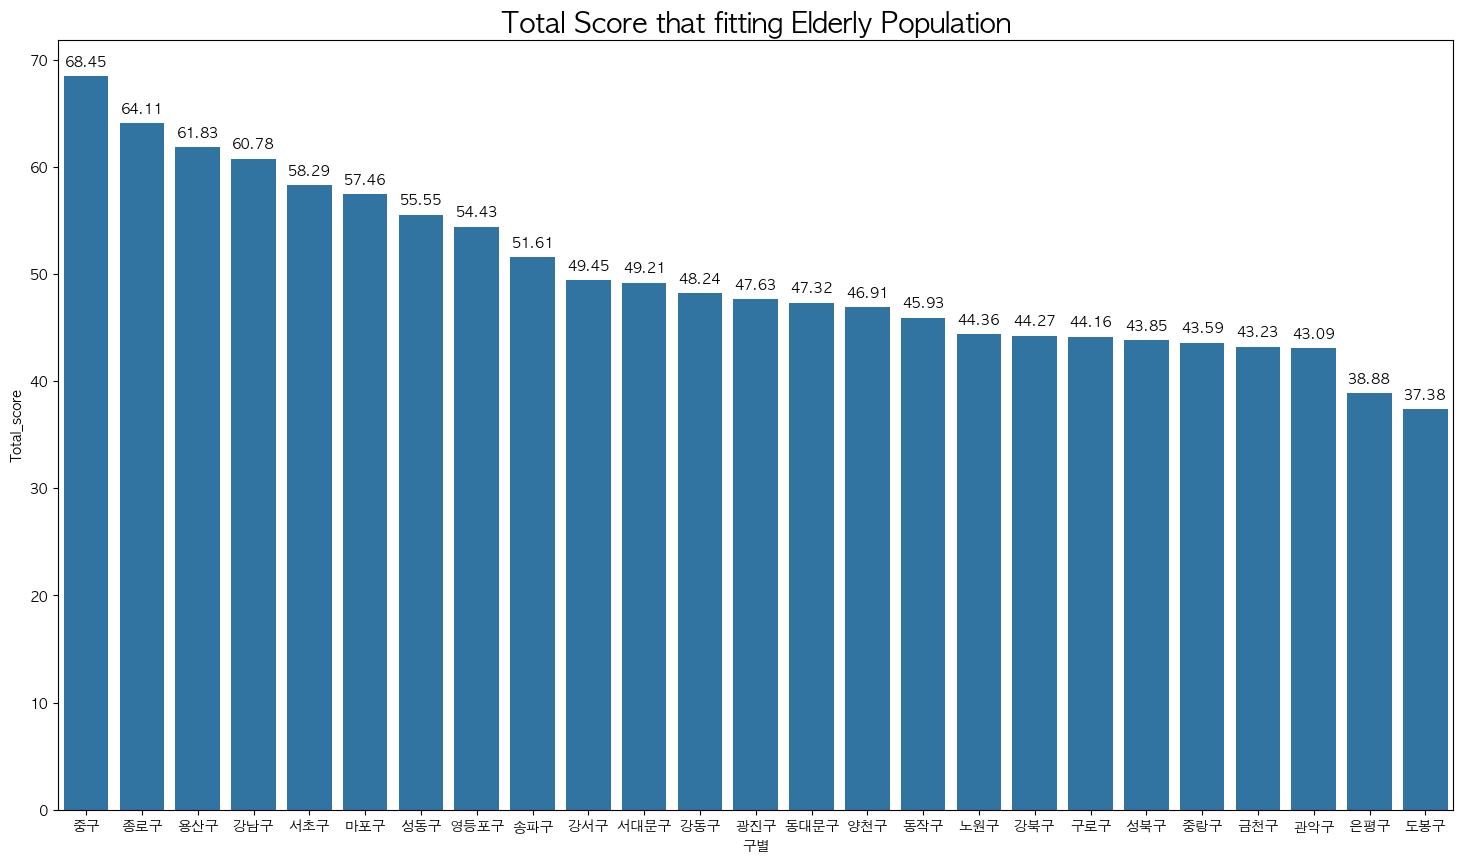

In [30]:
result_sorted = result.sort_values(by='Total_score', ascending=False)

plt.figure(figsize=(18, 10))
ax = sns.barplot(data=result_sorted, x='구별', y='Total_score')
plt.title('Total Score that fitting Elderly Population', fontdict={'fontsize' : 20})
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', 
                fontsize=10, color='black', 
                xytext=(0, 5), 
                textcoords='offset points')
plt.show()

/var/folders/76/295r32t542b3jtvsn34n34s00000gn/T/ipykernel_6214/1923324706.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(data=top_5, x='구별', y='Total_score', palette='Blues_d')


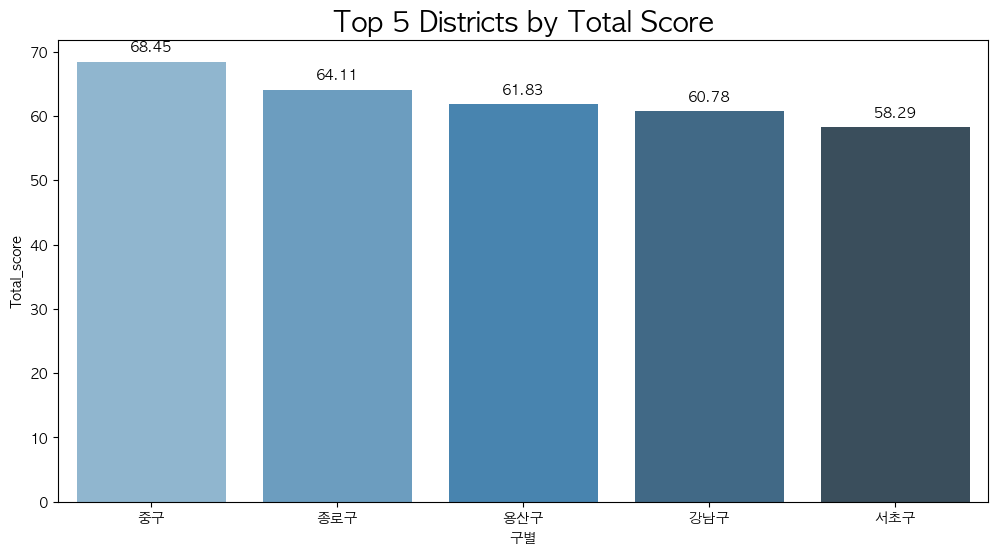

/var/folders/76/295r32t542b3jtvsn34n34s00000gn/T/ipykernel_6214/1923324706.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(data=bottom_5, x='구별', y='Total_score', palette='Reds_d')


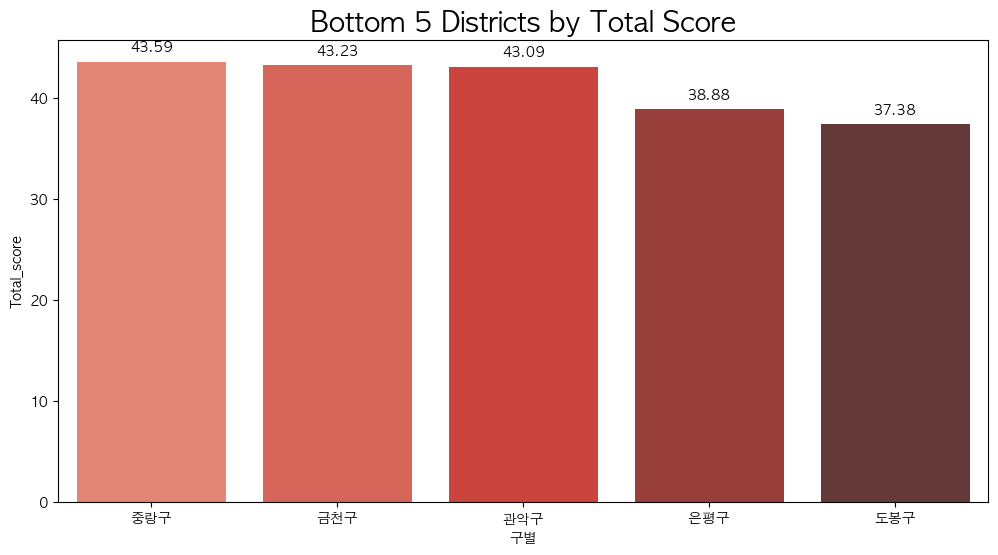

In [31]:
# 상위 5개 데이터
top_5 = result_sorted.head(5)

# 하위 5개 데이터
bottom_5 = result_sorted.tail(5)
# 상위 5개 데이터 시각화
plt.figure(figsize=(12, 6))
ax1 = sns.barplot(data=top_5, x='구별', y='Total_score', palette='Blues_d')
plt.title('Top 5 Districts by Total Score', fontdict={'fontsize': 20})
for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.2f}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='bottom', 
                 fontsize=10, color='black', 
                 xytext=(0, 5), 
                 textcoords='offset points')
plt.show()

# 하위 5개 데이터 시각화
plt.figure(figsize=(12, 6))
ax2 = sns.barplot(data=bottom_5, x='구별', y='Total_score', palette='Reds_d')
plt.title('Bottom 5 Districts by Total Score', fontdict={'fontsize': 20})
for p in ax2.patches:
    ax2.annotate(f'{p.get_height():.2f}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='bottom', 
                 fontsize=10, color='black', 
                 xytext=(0, 5), 
                 textcoords='offset points')
plt.show()


## 우선순위 1순위 의료접근성

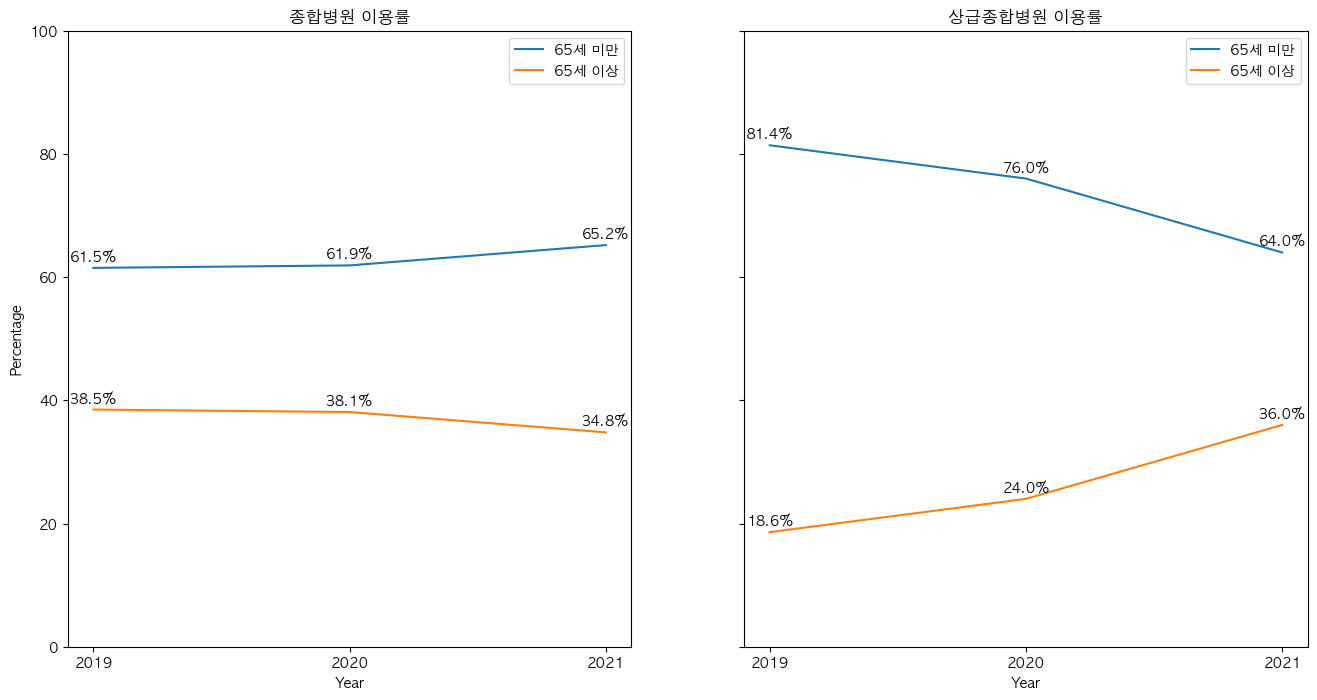

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

sns.lineplot(data=df1, x='Year', y='percentage', hue='Age', ax=axes[0])
axes[0].set_title("종합병원 이용률")
axes[0].set_ylabel("Percentage")
axes[0].set_xlabel("Year")
axes[0].legend(loc='upper right')
axes[0].set_ylim(0, 100)

for i in range(len(df1)):
    axes[0].text(df1['Year'][i], df1['percentage'][i] + 1, f"{df1['percentage'][i]}%", 
                fontsize=10, ha='center')

sns.lineplot(data=df2, x='Year', y='percentage', hue='Age', ax=axes[1])
axes[1].set_title("상급종합병원 이용률")
axes[1].set_ylabel("Percentage")
axes[1].set_xlabel("Year")
axes[1].legend(loc='upper right')

for i in range(len(df2)):
    axes[1].text(df2['Year'][i], df2['percentage'][i] + 1, f"{df2['percentage'][i]}%", 
                fontsize=10, ha='center')
plt.show()

* 65세 이상 병원 이용률이 종합병원인 경우, 소폭 감소하였지만, 상급 종합병원인 경우 대폭 증가하였다.
* 이를 통해 병원의 우선순위가 매우 높은 것을 확인할 수 있다.

In [173]:
station = pd.read_excel('./data/응용 지표(대중교통 이용인원)_20241221.xlsx')
station2 = pd.read_excel('./data/응용 지표(대중교통 이용인원)_20241221 (1).xlsx')
station3 = pd.read_excel('./data/응용 지표(대중교통 이용인원)_20241221 (2).xlsx')

In [180]:
stat = pd.concat([station, station2, station3], ignore_index=True)
stat.drop(index=[0, 2, 4], inplace=True)
stat.reset_index(drop=True, inplace=True)
stat

,시도코드,시도,년,합계,~,경로,국가유공자,어린이,외국인,일반인,장애인,청소년
0,11,서울특별시,2019,1443145759,3,112346401,2519049,16782733,6794548,1212703828,23751586,68247611
1,11,서울특별시,2020,1098488964,13,83342527,1957404,6998296,1051000,947871176,17900392,39368156
2,11,서울특별시,2021,1105857809,10,89546629,1926232,7882250,356934,943934844,17504976,44705934


## 우선순위 2순위 대중교통 접근성

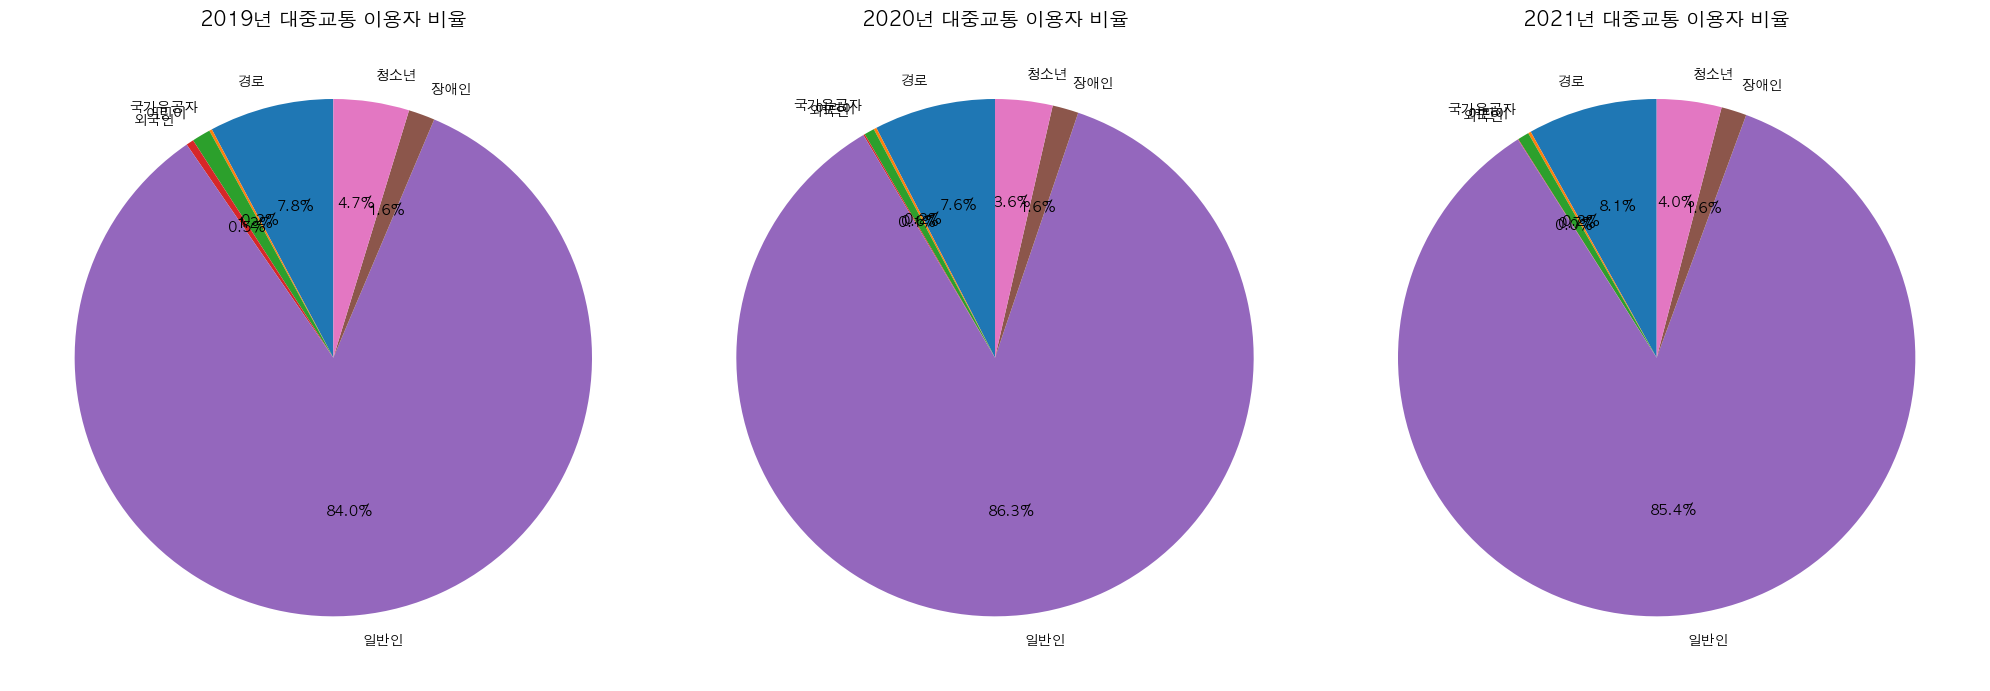

In [185]:
categories = ["경로", "국가유공자", "어린이", "외국인", "일반인", "장애인", "청소년"]

# Subplots 설정
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# 연도별 파이 차트 생성
for idx, year in enumerate([2019, 2020, 2021]):
    year_data = stat[stat["년"] == year]
    values = year_data[categories].iloc[0]
    axes[idx].pie(
        values,
        labels=categories,
        autopct="%.1f%%",
        startangle=90,
        colors=plt.cm.tab10.colors,
    )
    axes[idx].set_title(f"{year}년 대중교통 이용자 비율", fontsize=14)

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()

* 65세 이상 고령자 카드 -> 숨기고 ...?
* 생각하지 못한 부분이라 ...?

## 우선순위 3, 4순위 여가생활, 사회활동

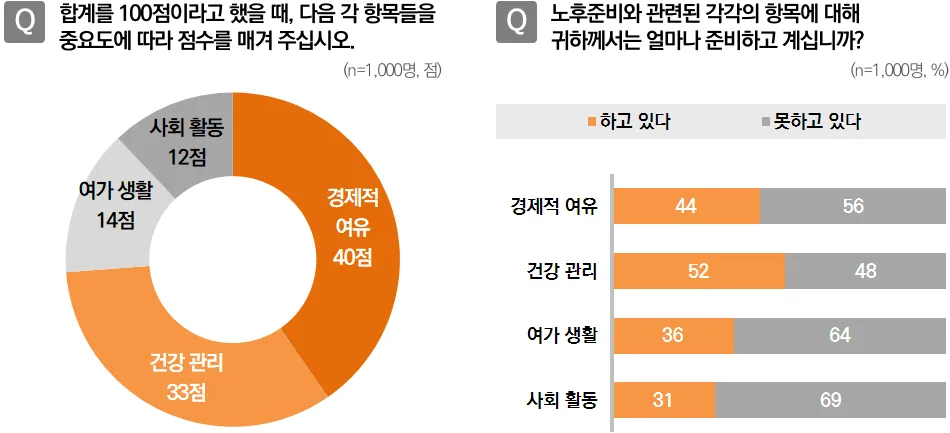

* 3대 요소 -> 의식주
* 의 중에서도 사실 공헌도 또는 참여...?
* 논문 ..? 자료를 찾아보면서..

## 우선순위 5순위 주거비용

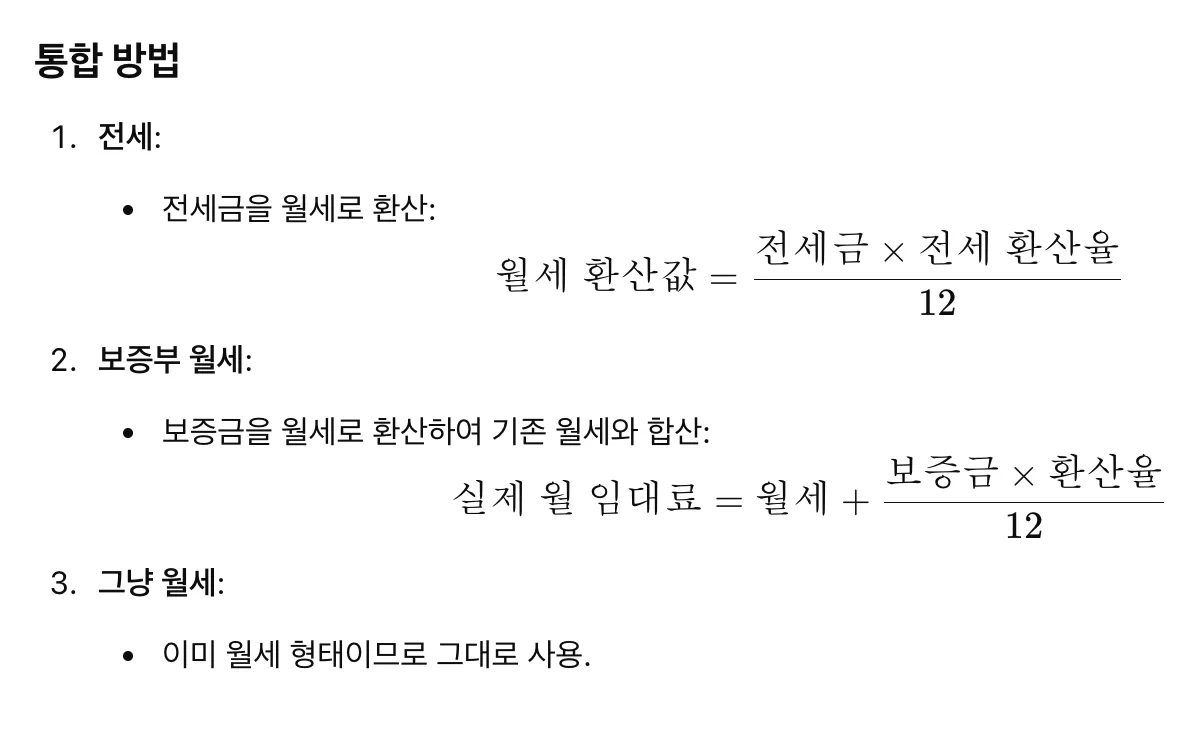